In [1]:
# Basic packages.
import pandas as pd
import numpy as np
import tensorflow as tf

# Visualization packages.
import seaborn as sns
import matplotlib.pyplot as plt

# Keras backend
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from keras import backend as K
sess = tf.compat.v1.Session()
K.set_session(sess)

2021-09-06 21:54:07.910138: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Necessary variables for file exploration.
DATA_DIR = 'data'
TRANSFORMED_DIR = 'transformed'
feature_file = 'transformed_features.csv'
response_file = 'transformed_responses.csv'

# Read in the data.
feature_df = pd.read_csv('{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, feature_file))
response_df = pd.read_csv('{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, response_file))
feature_df.shape, response_df.shape

((355, 59), (355, 45))

In [3]:
# Convert date to str & set as index.
feature_df['DATE'] = pd.to_datetime(feature_df['DATE'])
feature_df.set_index('DATE', drop=True, inplace=True)
response_df['Date'] = pd.to_datetime(response_df['Date'])
response_df.set_index('Date', drop=True, inplace=True)

In [4]:
response_df.shape

(355, 44)

# Look at the interactions of all 44 time series that could be possible responses

### Variational Autoencoders

In [11]:
# Which columns are desired
#print(feature_df.describe().transpose().to_latex())
print(response_df.describe().transpose()[['count', 'mean', 'std', 'min','max']].to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  count &      mean &       std &    min &    max \\
\midrule
US Stock Selection Value         &  355.0 &  0.145493 &  3.954556 & -17.99 &  26.86 \\
US Stock Selection Momentum      &  355.0 &  0.478197 &  4.793791 & -34.62 &  17.01 \\
US Stock Selection Defensive     &  355.0 &  0.825859 &  3.909319 & -15.67 &  15.36 \\
US Stock Selection Multi-style   &  355.0 &  0.483493 &  2.116313 &  -9.39 &  12.96 \\
Intl Stock Selection Value       &  355.0 &  0.376254 &  2.678681 & -15.41 &  15.10 \\
Intl Stock Selection Momentum    &  355.0 &  0.759211 &  3.535081 & -23.41 &  11.14 \\
Intl Stock Selection Defensive   &  355.0 &  0.919465 &  2.659838 &  -7.69 &  11.69 \\
Intl Stock Selection Multi-style &  355.0 &  0.684958 &  1.456693 &  -4.93 &   7.95 \\
Equity Indices Value             &  355.0 &  0.105521 &  2.349357 &  -7.78 &  11.56 \\
Equity Indices Momentum          &  355.0 &  0.357521 &  3.014521 & -10.41 &   9.36 \\
Equity Indices Carry           

Looking at the above, let's throw in all of the values and use a variational autoencoder to explore dimensionality reduction.

In [5]:
# Split into X_train and X_test (also y_train and y_test just in case)
# 80/20 split.
idx = round(feature_df.shape[0] * 0.8)
X_train, X_test = feature_df.iloc[:idx], feature_df.iloc[idx:]
y_train, y_test = response_df.iloc[:idx], response_df.iloc[idx:]
y_train.shape, y_test.shape

((284, 44), (71, 44))

In [6]:
# Set up network parameters
original_dim = y_train.shape[1]
input_shape = (original_dim, )
# Size of the intermediate dense layer for encoder and decoder.
intermediate_dim = 30
# Size of batch...
batch_size = 24
# Size of the latent dimension in encoder -- start w/ 2
latent_dim = 2
epochs = 100

In [7]:
# VAE = encoder + decoder
# 1/ Build encoder model.
inputs = tf.keras.layers.Input(shape=input_shape, name="encoder-input")
x = tf.keras.layers.Dense(intermediate_dim, activation="relu")(inputs)
z_mean = tf.keras.layers.Dense(latent_dim, name="z-mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z-log-var")(x)

In [8]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [9]:
# Instantiate Encoder model.
encoder = tf.keras.Model(inputs, z_mean)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder-input (InputLayer)   [(None, 44)]              0         
_________________________________________________________________
dense (Dense)                (None, 30)                1350      
_________________________________________________________________
z-mean (Dense)               (None, 2)                 62        
Total params: 1,412
Trainable params: 1,412
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Build the decoder model.
latent_inputs = tf.keras.layers.Input(shape=(latent_dim, ), name='z_sampling')
x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = tf.keras.layers.Dense(original_dim, activation='sigmoid')(x)

# Instnatiate the decoder model.
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                90        
_________________________________________________________________
dense_2 (Dense)              (None, 44)                1364      
Total params: 1,454
Trainable params: 1,454
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Instnatiate VAE model.
outputs = decoder(encoder(inputs))
vae = tf.keras.Model(inputs, outputs, name="vae-mlp")

In [12]:
def vae_loss(x, x_decoded_mean):
    xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [13]:
# Compile the model.
vae.compile(optimizer='rmsprop', loss=tf.keras.losses.KLD)

In [15]:
# Train the model.
results = vae.fit(y_train, y_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(y_test, y_test))

Train on 284 samples, validate on 71 samples
Epoch 1/100
284/284 [==============================] - 0s 783us/sample - loss: 10.3068 - val_loss: 6.2938
Epoch 2/100
284/284 [==============================] - 0s 41us/sample - loss: 8.2746 - val_loss: 4.7824
Epoch 3/100
284/284 [==============================] - 0s 38us/sample - loss: 5.8580 - val_loss: 3.1363
Epoch 4/100
284/284 [==============================] - 0s 41us/sample - loss: 3.5266 - val_loss: 1.6285
Epoch 5/100
284/284 [==============================] - 0s 39us/sample - loss: 1.6173 - val_loss: 0.4048
Epoch 6/100
284/284 [==============================] - 0s 37us/sample - loss: 0.1596 - val_loss: -0.5938
Epoch 7/100
284/284 [==============================] - 0s 37us/sample - loss: -0.9164 - val_loss: -1.3729
Epoch 8/100
284/284 [==============================] - 0s 47us/sample - loss: -1.6967 - val_loss: -1.9757
Epoch 9/100
284/284 [==============================] - 0s 36us/sample - loss: -2.2548 - val_loss: -2.4266
Epoch 10/1

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


284/284 [==============================] - 0s 44us/sample - loss: -3.1874 - val_loss: -3.3266
Epoch 17/100
284/284 [==============================] - 0s 36us/sample - loss: -3.1998 - val_loss: -3.3465
Epoch 18/100
284/284 [==============================] - 0s 36us/sample - loss: -3.2077 - val_loss: -3.3606
Epoch 19/100
284/284 [==============================] - 0s 46us/sample - loss: -3.2127 - val_loss: -3.3713
Epoch 20/100
284/284 [==============================] - 0s 40us/sample - loss: -3.2159 - val_loss: -3.3786
Epoch 21/100
284/284 [==============================] - 0s 36us/sample - loss: -3.2179 - val_loss: -3.3835
Epoch 22/100
284/284 [==============================] - 0s 44us/sample - loss: -3.2189 - val_loss: -3.3874
Epoch 23/100
284/284 [==============================] - 0s 42us/sample - loss: -3.2196 - val_loss: -3.3904
Epoch 24/100
284/284 [==============================] - 0s 40us/sample - loss: -3.2201 - val_loss: -3.3926
Epoch 25/100
284/284 [============================

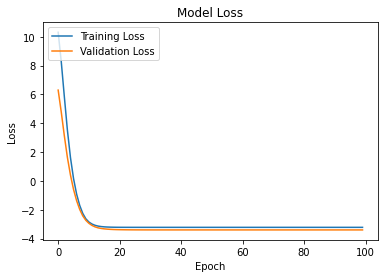

In [16]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [18]:
# Visualize using the mainfold learning --> tSNE
y_compressed_train = vae.predict(y_train)
y_compressed_valid = vae.predict(y_test)

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


As the above image shows, we find some stable training for a variational autoencoder for our 24 